In [1]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import time
import xgboost as xgb

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

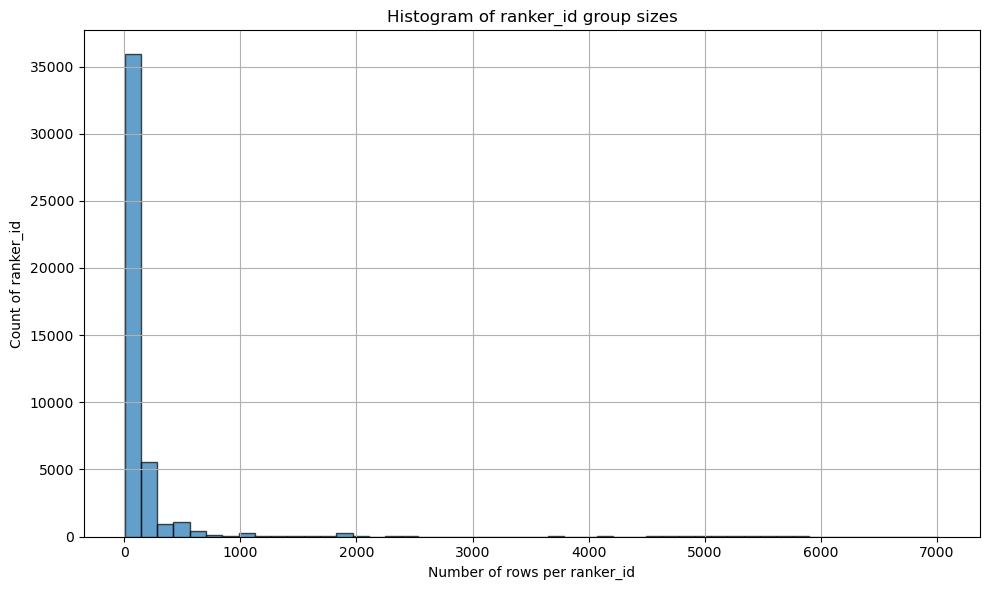

In [14]:
import polars as pl
import matplotlib.pyplot as plt

# Load data
train = pl.read_parquet('data/test_filled.parquet')

# 計算每個 ranker_id 出現次數
ranker_counts = (
    train
    .group_by("ranker_id")
    .agg(pl.len().alias("n_rows"))
    .sort("n_rows")
)

# 轉成 pandas
ranker_counts_pd = ranker_counts.to_pandas()

# 畫 histogram
plt.figure(figsize=(10,6))
plt.hist(ranker_counts_pd["n_rows"], bins=50, edgecolor="k", alpha=0.7)
plt.xlabel("Number of rows per ranker_id")
plt.ylabel("Count of ranker_id")
plt.title("Histogram of ranker_id group sizes")
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
ranker_counts_filtered = ranker_counts.filter(pl.col("n_rows") >= 3)
summary_filtered = ranker_counts_filtered.select([
    pl.col("n_rows").min().alias("min"),
    pl.col("n_rows").max().alias("max"),
    pl.col("n_rows").mean().alias("mean"),
    pl.col("n_rows").median().alias("median"),
    pl.col("n_rows").quantile(0.25, "nearest").alias("25%"),
    pl.col("n_rows").quantile(0.75, "nearest").alias("75%"),
    pl.col("n_rows").quantile(0.85, "nearest").alias("85%"),
    pl.col("n_rows").quantile(0.95, "nearest").alias("95%"),
    pl.col("n_rows").std().alias("std"),
])

print(summary_filtered)


shape: (1, 9)
┌─────┬──────┬────────────┬────────┬───┬───────┬───────┬───────┬────────────┐
│ min ┆ max  ┆ mean       ┆ median ┆ … ┆ 75%   ┆ 85%   ┆ 95%   ┆ std        │
│ --- ┆ ---  ┆ ---        ┆ ---    ┆   ┆ ---   ┆ ---   ┆ ---   ┆ ---        │
│ u32 ┆ u32  ┆ f64        ┆ f64    ┆   ┆ f64   ┆ f64   ┆ f64   ┆ f64        │
╞═════╪══════╪════════════╪════════╪═══╪═══════╪═══════╪═══════╪════════════╡
│ 3   ┆ 7022 ┆ 159.889564 ┆ 39.0   ┆ … ┆ 121.0 ┆ 212.0 ┆ 517.0 ┆ 535.102201 │
└─────┴──────┴────────────┴────────┴───┴───────┴───────┴───────┴────────────┘


In [1]:
import os
import pandas as pd

def load_label_features(
    model_dir: str,
    split_labels: list,
    top_n: int = None
):
    """
    從模型資料夾讀取每個分群的特徵重要性檔案，回傳每個label的features list。
    
    參數:
    - model_dir: 模型資料夾
    - split_labels: 分群名稱list
    - top_n: 如果指定，只取前N個特徵；否則用第一個min_rank=9999為止

    回傳:
    - dict(label -> features list)
    """
    label_features = {}

    for label in split_labels:
        model_importance_dir = os.path.join(model_dir, "model_importance")
        csv_path = os.path.join(model_importance_dir, f"feature_importance_{label}_all_features.csv")

        df = pd.read_csv(csv_path)

        if top_n is not None:
            # 直接取前top_n
            feats = df.iloc[:top_n]["feature"].tolist()
            print(f"\n✅ {label}: 取前 {top_n} 個特徵")
        else:
            idx_first_unused = df[df["min_rank"] == 9999].index.min()
            feats = df["feature"].tolist()
            exclude_cols = {"n_rows", "group_category"}
            feats = [f for f in feats if f not in exclude_cols]

            print(f"\n✅ {label}: 第 {idx_first_unused} 名後都是完全未使用的特徵")
            print("✅ 第一個未使用特徵：")
            print(df.iloc[idx_first_unused])

        label_features[label] = feats

    # 印出所有分群features數量
    for label in split_labels:
        print(f"{label}: {len(label_features[label])} features")

    return label_features


In [2]:

model_dir = "model_output/all_features_xgb"

# 先把每個分群都讀一遍feature importance
split_labels = ["small", "medium", "large", 'xlarge']

label_features = load_label_features(
    model_dir=model_dir,
    split_labels=split_labels)



✅ small: 第 155 名後都是完全未使用的特徵
✅ 第一個未使用特徵：
feature            legs0_segments2_departureFrom_airport_iata
weight                                                    NaN
weight_rank_pos                                        9999.0
gain                                                      NaN
gain_rank_pos                                          9999.0
cover                                                     NaN
cover_rank_pos                                         9999.0
min_rank                                               9999.0
Name: 155, dtype: object

✅ medium: 第 165 名後都是完全未使用的特徵
✅ 第一個未使用特徵：
feature            legs0_segments3_marketingCarrier_code_in_ff
weight                                                     NaN
weight_rank_pos                                         9999.0
gain                                                       NaN
gain_rank_pos                                           9999.0
cover                                                      NaN
cover_rank_pos    

In [6]:
import numpy as np
import polars as pl

# 讀取
train_filled = pl.read_parquet("data/train_filled.parquet")

# 排除欄
needed_cols = [
     'ranker_id', 'selected'
]
remove = ['profileId', 'requestDate',
    'legs0_departureAt', 'legs0_arrivalAt', 'legs1_departureAt', 'legs1_arrivalAt', "n_rows", "__index_level_0__","Id'"]

exclude_cols = needed_cols + remove

feature_cols = [c for c in train_filled.columns if c not in exclude_cols]

# 轉 float32
float64_cols = [c for c in feature_cols if train_filled[c].dtype == pl.Float64]
train_filled = train_filled.with_columns(
    [pl.col(c).cast(pl.Float32) for c in float64_cols]
)

all_features = feature_cols+needed_cols
train_filled = train_filled.select(all_features)

In [3]:
# 找字串欄
str_cols = [c for c in train_filled.columns if train_filled[c].dtype in (pl.Utf8, pl.String)]
# 找數值欄
numeric_cols = [c for c in train_filled.columns if train_filled[c].dtype.is_numeric()]
# 找布林欄
bool_cols = [c for c in train_filled.columns if train_filled[c].dtype == pl.Boolean]

print(f"✅ 共找到 {len(str_cols)} 個字串欄位")
print(f"✅ 共找到 {len(numeric_cols)} 個數值欄位")
print(f"✅ 共找到 {len(bool_cols)} 個布林欄位")


✅ 共找到 2 個字串欄位
✅ 共找到 227 個數值欄位
✅ 共找到 0 個布林欄位


In [7]:
from scripts.group_wise import split_data_by_group_size

result = split_data_by_group_size(
    train_filled,
    bins=[3, 212, 517, 1200 , None],
    labels=["small", "medium", "large", "xlarge" ],
    output_dir="model_output/all_features_xgb/v2_1/train_dataset",
    unused_label_features=remove
)


label_features = result["used_label_features"]

# label_features = {
#     label: [f for f in feats if f not in exclude_cols]
#     for label, feats in label_features.items()
# }

import gc
del train_filled
gc.collect()

/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_96230/4051774140.py:25: DeprecationWarning: `DataFrame.with_row_count` is deprecated; use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  df = df.with_row_count("global_row_nr")
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_96230/4051774140.py:29: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias("n_rows"))


✅ small: 4330376 rows, approx 3877.84 MB
💾 已寫入 model_output/all_features_xgb/v2_1/train_dataset/small.parquet
✅ medium: 4386076 rows, approx 3927.08 MB
💾 已寫入 model_output/all_features_xgb/v2_1/train_dataset/medium.parquet
✅ large: 4689134 rows, approx 4198.30 MB
💾 已寫入 model_output/all_features_xgb/v2_1/train_dataset/large.parquet
✅ xlarge: 4733813 rows, approx 4237.51 MB
💾 已寫入 model_output/all_features_xgb/v2_1/train_dataset/xlarge.parquet
✅ 分群統計：
shape: (4, 4)
┌────────────────┬──────────┬────────────┬────────────────────┐
│ group_category ┆ n_groups ┆ total_rows ┆ avg_rows_per_group │
│ ---            ┆ ---      ┆ ---        ┆ ---                │
│ str            ┆ u32      ┆ u32        ┆ f64                │
╞════════════════╪══════════╪════════════╪════════════════════╡
│ large          ┆ 6173     ┆ 4689134    ┆ 759.619958         │
│ medium         ┆ 13487    ┆ 4386076    ┆ 325.207681         │
│ small          ┆ 80679    ┆ 4330376    ┆ 53.674141          │
│ xlarge         ┆ 165

/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_96230/4051774140.py:110: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("n_groups"),


33

In [ ]:
test_filled = pl.read_parquet("data/test_filled.parquet")
# 取得 test_filled 所有欄位
test_cols = set(test_filled.columns)

# 逐一檢查
for label, feats in label_features.items():
    missing = [f for f in feats if f not in test_cols]
    if missing:
        print(f"⚠️ Label '{label}' 缺少 {len(missing)} 個features:")
        print(missing)
    else:
        print(f"✅ Label '{label}' 所有features都存在於test_filled")
del test_filled
gc.collect()

⚠️ Label 'small' 缺少 2 個features:
['global_row_nr', 'selected']
⚠️ Label 'medium' 缺少 2 個features:
['global_row_nr', 'selected']
⚠️ Label 'large' 缺少 2 個features:
['global_row_nr', 'selected']
⚠️ Label 'xlarge' 缺少 2 個features:
['global_row_nr', 'selected']
⚠️ Label 'xxlarge' 缺少 2 個features:
['global_row_nr', 'selected']


0

In [8]:
import os
import gc
import xgboost as xgb
import numpy as np
import polars as pl
from scripts.group_wise import prepare_train_val_split
from scripts.hitrate import compute_hitrate_at_3
import json

# 你的分群 parquet 存放目錄
train_dataset_dir = "model_output/all_features_xgb/v1/v2_1/train_dataset/"

# 確保目錄存在
os.makedirs(train_dataset_dir, exist_ok=True)

# 你的model_dir
model_dir = "model_output/all_features_xgb/v1/v2_1"
os.makedirs(model_dir, exist_ok=True)
print(f"✅ Model folder: {model_dir}")

# 你的xgb_params
xgb_params = {
    'objective': 'rank:pairwise',
    'eval_metric': 'ndcg@3',
    'max_depth': 11,
    'min_child_weight': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'lambda': 10.0,
    'learning_rate': 0.05,
    'seed': 42,
    'n_jobs': -1,
}

# 儲存成JSON
params_path = os.path.join(model_dir, "xgb_params.json")

with open(params_path, "w") as f:
    json.dump(xgb_params, f, indent=4)

print(f"✅ 參數已存檔: {params_path}")


split_labels = ["small", "medium", "large", "xlarge" ]

all_groups_val_np = []
all_y_val_np = []
all_val_preds = []
hitrate_per_group = {}

for label in split_labels:
    print(f"\n🚀 處理分群: {label}")

    parquet_path = os.path.join(train_dataset_dir, f"{label}.parquet")
    if not os.path.exists(parquet_path):
        print(f"⚠️ {label} parquet 檔不存在，跳過")
        continue

    data = pl.read_parquet(parquet_path)

    split_result = prepare_train_val_split(
        result={"split_data": {label: data}},
        split_label=label,
        feature_cols=None,
        train_fraction=0.8
    )
    xgb_model = xgb.train(
        xgb_params,
        split_result["dtrain"],
        num_boost_round=500,
        evals=[(split_result["dtrain"], "train"), (split_result["dval"], "val")],
        early_stopping_rounds=50,
        verbose_eval=20
    )

    model_path = os.path.join(model_dir, f"xgb_ranker_{label}.bin")
    xgb_model.save_model(model_path)
    print(f"✅ 已儲存模型: {model_path}")

    val_preds = xgb_model.predict(split_result["dval"])

    hitrate = compute_hitrate_at_3(
        split_result["groups_val_np"],
        split_result["y_val_np"],
        val_preds
    )
    hitrate_per_group[label] = hitrate

    all_groups_val_np.append(split_result["groups_val_np"])
    all_y_val_np.append(split_result["y_val_np"])
    all_val_preds.append(val_preds)

    del xgb_model, val_preds, split_result, data
    gc.collect()
    print("🧹 記憶體已清理")

print("\n⚡ 合併所有驗證結果計算 HitRate ⚡")
all_groups_val_np = np.concatenate(all_groups_val_np)
all_y_val_np = np.concatenate(all_y_val_np)
all_val_preds = np.concatenate(all_val_preds)

overall_hitrate = compute_hitrate_at_3(
    all_groups_val_np,
    all_y_val_np,
    all_val_preds
)

print("\n💡 每組 Hitrate：")
for label, h in hitrate_per_group.items():
    print(f"{label}: {h:.4f}")

print(f"\n🎯 全部合併 HitRate: {overall_hitrate:.4f}")

# 將 hitrate 寫入 CSV
hitrate_records = [
    {"split_label": label, "hitrate": h}
    for label, h in hitrate_per_group.items()
]
hitrate_records.append({"split_label": "overall", "hitrate": overall_hitrate})

hitrate_df = pl.DataFrame(hitrate_records)
csv_path = os.path.join(model_dir, "hitrate_summary.csv")
hitrate_df.write_csv(csv_path)
print(f"\n✅ 已儲存所有 Hitrate 結果至 {csv_path}")


✅ Model folder: model_output/all_features_xgb/v1/v2_1
✅ 參數已存檔: model_output/all_features_xgb/v1/v2_1/xgb_params.json

🚀 處理分群: small
✅ Train: 3467689 rows, 64543 groups
✅ Val: 862687 rows, 16136 groups
[0]	train-ndcg@3:0.40877	val-ndcg@3:0.39612
[20]	train-ndcg@3:0.54602	val-ndcg@3:0.48002
[40]	train-ndcg@3:0.58143	val-ndcg@3:0.49338
[60]	train-ndcg@3:0.60537	val-ndcg@3:0.50434
[80]	train-ndcg@3:0.62572	val-ndcg@3:0.51198
[100]	train-ndcg@3:0.64234	val-ndcg@3:0.51932
[120]	train-ndcg@3:0.65610	val-ndcg@3:0.52537
[140]	train-ndcg@3:0.67106	val-ndcg@3:0.53139
[160]	train-ndcg@3:0.68149	val-ndcg@3:0.53567
[180]	train-ndcg@3:0.69310	val-ndcg@3:0.54022
[200]	train-ndcg@3:0.70671	val-ndcg@3:0.54528
[220]	train-ndcg@3:0.72172	val-ndcg@3:0.55030
[240]	train-ndcg@3:0.73700	val-ndcg@3:0.55372
[260]	train-ndcg@3:0.74804	val-ndcg@3:0.55636
[280]	train-ndcg@3:0.76151	val-ndcg@3:0.55958
[300]	train-ndcg@3:0.77124	val-ndcg@3:0.56239
[320]	train-ndcg@3:0.78029	val-ndcg@3:0.56385
[340]	train-ndcg@3:0.78

/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_96230/2945985282.py:77: UserWarning: [15:11:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_path)


✅ HitRate@3 (groups size in [10, inf]): 0.6411
🧹 記憶體已清理

🚀 處理分群: medium
✅ Train: 3510128 rows, 10789 groups
✅ Val: 875948 rows, 2698 groups
[0]	train-ndcg@3:0.08922	val-ndcg@3:0.08108
[20]	train-ndcg@3:0.29771	val-ndcg@3:0.17268
[40]	train-ndcg@3:0.35552	val-ndcg@3:0.18725
[60]	train-ndcg@3:0.40815	val-ndcg@3:0.19601
[80]	train-ndcg@3:0.45388	val-ndcg@3:0.20499
[100]	train-ndcg@3:0.50841	val-ndcg@3:0.21677
[120]	train-ndcg@3:0.55642	val-ndcg@3:0.23155
[140]	train-ndcg@3:0.59789	val-ndcg@3:0.24125
[160]	train-ndcg@3:0.62985	val-ndcg@3:0.24713
[180]	train-ndcg@3:0.67060	val-ndcg@3:0.25535
[200]	train-ndcg@3:0.70862	val-ndcg@3:0.26613
[220]	train-ndcg@3:0.73713	val-ndcg@3:0.27229
[240]	train-ndcg@3:0.76051	val-ndcg@3:0.27568
[260]	train-ndcg@3:0.78010	val-ndcg@3:0.28121
[280]	train-ndcg@3:0.80193	val-ndcg@3:0.28510
[300]	train-ndcg@3:0.82331	val-ndcg@3:0.29026
[320]	train-ndcg@3:0.85032	val-ndcg@3:0.29485
[340]	train-ndcg@3:0.87182	val-ndcg@3:0.30123
[360]	train-ndcg@3:0.89099	val-ndcg@3:

/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_96230/2945985282.py:77: UserWarning: [15:18:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_path)


✅ HitRate@3 (groups size in [10, inf]): 0.3721
🧹 記憶體已清理

🚀 處理分群: large
✅ Train: 3765309 rows, 4938 groups
✅ Val: 923825 rows, 1235 groups
[0]	train-ndcg@3:0.04297	val-ndcg@3:0.03389
[20]	train-ndcg@3:0.28353	val-ndcg@3:0.12121
[40]	train-ndcg@3:0.34149	val-ndcg@3:0.14041
[60]	train-ndcg@3:0.41645	val-ndcg@3:0.15057
[80]	train-ndcg@3:0.50312	val-ndcg@3:0.17014
[100]	train-ndcg@3:0.59073	val-ndcg@3:0.18174
[120]	train-ndcg@3:0.65853	val-ndcg@3:0.19378
[140]	train-ndcg@3:0.70370	val-ndcg@3:0.20271
[160]	train-ndcg@3:0.74779	val-ndcg@3:0.21415
[180]	train-ndcg@3:0.78085	val-ndcg@3:0.22362
[200]	train-ndcg@3:0.80538	val-ndcg@3:0.22480
[220]	train-ndcg@3:0.83373	val-ndcg@3:0.23271
[240]	train-ndcg@3:0.85915	val-ndcg@3:0.23586
[260]	train-ndcg@3:0.88123	val-ndcg@3:0.23964
[280]	train-ndcg@3:0.90242	val-ndcg@3:0.24185
[300]	train-ndcg@3:0.91387	val-ndcg@3:0.24426
[320]	train-ndcg@3:0.92577	val-ndcg@3:0.24993
[340]	train-ndcg@3:0.93441	val-ndcg@3:0.25196
[360]	train-ndcg@3:0.94233	val-ndcg@3:0.

/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_96230/2945985282.py:77: UserWarning: [15:25:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_path)


✅ HitRate@3 (groups size in [10, inf]): 0.2964
🧹 記憶體已清理

🚀 處理分群: xlarge
✅ Train: 3761676 rows, 1322 groups
✅ Val: 972137 rows, 331 groups
[0]	train-ndcg@3:0.01194	val-ndcg@3:0.00834
[20]	train-ndcg@3:0.43881	val-ndcg@3:0.09157
[40]	train-ndcg@3:0.58661	val-ndcg@3:0.09991
[60]	train-ndcg@3:0.63901	val-ndcg@3:0.10214
[80]	train-ndcg@3:0.69969	val-ndcg@3:0.12264
[100]	train-ndcg@3:0.75482	val-ndcg@3:0.12948
[120]	train-ndcg@3:0.80428	val-ndcg@3:0.13545
[140]	train-ndcg@3:0.84703	val-ndcg@3:0.14030
[160]	train-ndcg@3:0.87412	val-ndcg@3:0.14444
[180]	train-ndcg@3:0.90188	val-ndcg@3:0.14865
[200]	train-ndcg@3:0.91691	val-ndcg@3:0.15764
[220]	train-ndcg@3:0.93236	val-ndcg@3:0.15685
[240]	train-ndcg@3:0.94690	val-ndcg@3:0.16257
[260]	train-ndcg@3:0.95972	val-ndcg@3:0.15883
[280]	train-ndcg@3:0.96790	val-ndcg@3:0.16447
[300]	train-ndcg@3:0.97111	val-ndcg@3:0.16749
[320]	train-ndcg@3:0.97551	val-ndcg@3:0.16828
[340]	train-ndcg@3:0.97767	val-ndcg@3:0.17505
[360]	train-ndcg@3:0.98077	val-ndcg@3:0.

/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_96230/2945985282.py:77: UserWarning: [15:33:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_path)


✅ HitRate@3 (groups size in [10, inf]): 0.2054
🧹 記憶體已清理

⚡ 合併所有驗證結果計算 HitRate ⚡
✅ HitRate@3 (groups size in [10, inf]): 0.5696

💡 每組 Hitrate：
small: 0.6411
medium: 0.3721
large: 0.2964
xlarge: 0.2054

🎯 全部合併 HitRate: 0.5696

✅ 已儲存所有 Hitrate 結果至 model_output/all_features_xgb/v1/v2_1/hitrate_summary.csv


# model 

In [9]:
# 指定你的模型資料夾
from scripts.group_wise import export_xgb_feature_importance
model_dir = "model_output/all_features_xgb/v1/v2_1"

# 所有label
labels = ["small", "medium", "large", "xlarge"]

# 逐一跑
for lbl in labels:
    print(f"\n🚀 處理模型: {lbl}")
    df_importance = export_xgb_feature_importance(
        model_dir=model_dir,
        label=lbl,
    )


🚀 處理模型: small
✅ 已讀取模型 model_output/all_features_xgb/v1/v2_1/xgb_ranker_small.bin
✅ 已輸出所有特徵重要性到 model_output/all_features_xgb/v1/v2_1/model_importance/feature_importance_small_all_features.csv

🚀 處理模型: medium
✅ 已讀取模型 model_output/all_features_xgb/v1/v2_1/xgb_ranker_medium.bin
✅ 已輸出所有特徵重要性到 model_output/all_features_xgb/v1/v2_1/model_importance/feature_importance_medium_all_features.csv

🚀 處理模型: large
✅ 已讀取模型 model_output/all_features_xgb/v1/v2_1/xgb_ranker_large.bin
✅ 已輸出所有特徵重要性到 model_output/all_features_xgb/v1/v2_1/model_importance/feature_importance_large_all_features.csv

🚀 處理模型: xlarge
✅ 已讀取模型 model_output/all_features_xgb/v1/v2_1/xgb_ranker_xlarge.bin
✅ 已輸出所有特徵重要性到 model_output/all_features_xgb/v1/v2_1/model_importance/feature_importance_xlarge_all_features.csv


In [10]:
from scripts.group_wise import export_common_feature_ranks

df_common = export_common_feature_ranks(
    labels=["small", "medium", "large", "xlarge"],
    model_importance_dir=f"{model_dir}/model_importance")


✅ 已讀 small: 225 rows
✅ 已讀 medium: 225 rows
✅ 已讀 large: 225 rows
✅ 已讀 xlarge: 225 rows

🎯 所有模型共同出現特徵: 225

✅ 已輸出共同特徵到 model_output/all_features_xgb/v1/v2_1/model_importance/common_features_with_ranks.csv


# Predcit

In [13]:
from scripts.group_wise import split_data_by_group_size_test, load_used_features_from_importance_csv
import numpy as np
import polars as pl

# 讀取
test_filled = pl.read_parquet("data/test_filled.parquet")

model_dir = "model_output/all_features_xgb/v1/v2_1/"


# 排除欄
exclude_cols = [
    'Id', 'ranker_id', 'selected', 'profileId', 'requestDate', 'frequentFlyer',
    'legs0_departureAt', 'legs0_arrivalAt', 'legs1_departureAt', 'legs1_arrivalAt',
    'miniRules0_percentage', 'miniRules1_percentage',
    'pricingInfo_passengerCount'
]
label_list = ["small", "medium", "large", "xlarge"]

feature_dict = load_used_features_from_importance_csv(
    model_importance_dir=f"{model_dir}/model_importance",
    labels=label_list
)

# 看一個範例
print(feature_dict["medium"])


result = split_data_by_group_size_test(
    test_filled,
    bins=[0, 212, 517, 1200 , None],
    labels=label_list
)

✅ small: 共 225 個用到的特徵
✅ medium: 共 225 個用到的特徵
✅ large: 共 225 個用到的特徵
✅ xlarge: 共 225 個用到的特徵
['price_per_duration_rank', 'total_num_transfers_rank', 'total_is_min_transfers', 'price_from_median_zscore', 'legs1_mean_cabin', 'price_percentile', 'legs0_num_transfers_rank', 'companyID', 'legs0_mean_cabin', 'legs0_segments0_flightNumber', 'price_per_duration', 'both_legs_carrier_all_same', 'is_cheapest', 'price_minus_fee_rank', 'legs1_max_duration_cabin', 'legs1_weighted_mean_cabin', 'price_per_fee_rank', 'legs0_is_min_transfers', 'totalPrice_rank', 'pricingInfo_isAccessTP', 'total_weighted_mean_cabin', 'days_before_departure', 'total_duration', 'has_access_tp', 'legs0_departureAt_hour', 'legs1_segments0_baggageAllowance_quantity', 'legs0_arrivalAt_hour', 'price_per_fee', 'legs0_segments0_baggageAllowance_quantity', 'legs0_segments0_operatingCarrier_code_in_ff', 'price_per_tax', 'baggage_total_rank', 'legs1_segments1_flightNumber', 'log_price', 'legs0_weighted_mean_cabin', 'duration_ratio', 'p

In [9]:
# 取得 test_filled 所有欄位
test_cols = set(test_filled.columns)

# 逐一檢查
for label, feats in feature_dict.items():
    missing = [f for f in feats if f not in test_cols]
    if missing:
        print(f"⚠️ Label '{label}' 缺少 {len(missing)} 個features:")
        print(missing)
    else:
        print(f"✅ Label '{label}' 所有features都存在於test_filled")


✅ Label 'small' 所有features都存在於test_filled
✅ Label 'medium' 所有features都存在於test_filled
✅ Label 'large' 所有features都存在於test_filled
✅ Label 'xlarge' 所有features都存在於test_filled
✅ Label 'xxlarge' 所有features都存在於test_filled


In [8]:
# 找字串欄
import polars as pl
str_cols = [c for c in test_filled.columns if test_filled[c].dtype in (pl.Utf8, pl.String)]
# 找數值欄
numeric_cols = [c for c in test_filled.columns if test_filled[c].dtype.is_numeric()]
# 找布林欄
bool_cols = [c for c in test_filled.columns if test_filled[c].dtype == pl.Boolean]

print(f"✅ 共找到 {len(str_cols)} 個字串欄位")
print(f"✅ 共找到 {len(numeric_cols)} 個數值欄位")
print(f"✅ 共找到 {len(bool_cols)} 個布林欄位")


✅ 共找到 6 個字串欄位
✅ 共找到 228 個數值欄位
✅ 共找到 0 個布林欄位


In [10]:
test_filled[str_cols]

frequentFlyer,legs0_departureAt,legs0_arrivalAt,legs1_departureAt,legs1_arrivalAt,ranker_id
str,str,str,str,str,str
"""missing""","""2024-12-19T06:50:00""","""2024-12-19T11:20:00""","""2024-12-21T21:10:00""","""2024-12-21T21:55:00""","""c9373e5f772e43d593dd6ad2fa90f6…"
"""missing""","""2024-12-19T06:50:00""","""2024-12-19T11:20:00""","""2024-12-21T21:10:00""","""2024-12-21T21:55:00""","""c9373e5f772e43d593dd6ad2fa90f6…"
"""missing""","""2024-12-19T06:50:00""","""2024-12-19T11:20:00""","""2024-12-21T21:10:00""","""2024-12-21T21:55:00""","""c9373e5f772e43d593dd6ad2fa90f6…"
"""missing""","""2024-12-19T08:25:00""","""2024-12-19T12:45:00""","""2024-12-21T12:00:00""","""2024-12-21T12:35:00""","""c9373e5f772e43d593dd6ad2fa90f6…"
"""missing""","""2024-12-19T08:25:00""","""2024-12-19T12:45:00""","""2024-12-21T12:00:00""","""2024-12-21T12:35:00""","""c9373e5f772e43d593dd6ad2fa90f6…"
…,…,…,…,…,…
"""missing""","""2025-01-08T09:05:00""","""2025-01-08T12:50:00""","""missing""","""missing""","""c5622e0de0594bde95a4dd8c1fcff7…"
"""missing""","""2025-01-08T21:25:00""","""2025-01-09T01:10:00""","""missing""","""missing""","""c5622e0de0594bde95a4dd8c1fcff7…"
"""missing""","""2025-01-08T21:25:00""","""2025-01-09T01:10:00""","""missing""","""missing""","""c5622e0de0594bde95a4dd8c1fcff7…"


In [ ]:
import xgboost as xgb
import numpy as np
from scripts.group_wise import prepare_prediction
import os

model_dir = "model_output/all_features_xgb/v1/v2_1/"
split_labels = ["small", "medium", "large", "xlarge"]

all_groups_val_np = []
all_X_val_np = []
all_val_preds = []
all_rows_val_np = []

for label in split_labels:
    print(f"\n🚀 處理分群: {label}")

    # 先讀模型
    model_path = os.path.join(model_dir, f"xgb_ranker_{label}.bin")
    xgb_model = xgb.Booster(model_file=model_path)

    # 提取模型feature順序
    model_features = xgb_model.feature_names
    if model_features is None:
        raise ValueError(f"模型 {model_path} 沒有feature_names，請確認訓練時有指定 feature_names")

    print(f"✅ 模型 {label} feature順序共 {len(model_features)} 欄")

    # 準備資料
    split_result = prepare_prediction(
        result=result,
        split_label=label,
        feature_cols=model_features,  # 直接用模型順序
    )

    # 再次驗證 feature 完整性
    feature_in_data = set(split_result["feature_cols"])
    missing_in_data = [f for f in model_features if f not in feature_in_data]
    if missing_in_data:
        raise ValueError(f"❌ 模型feature在資料中找不到: {missing_in_data}")

    # 把X_np依照模型特徵順序重新選取
    df_for_reorder = result["split_data"][label].select(model_features)
    X_np_sorted = df_for_reorder.to_numpy()

    dval = xgb.DMatrix(X_np_sorted, feature_names=model_features)
    dval.set_group(split_result["group_sizes"])

    # 預測
    val_preds = xgb_model.predict(dval)
    print(val_preds)
    all_groups_val_np.append(split_result["groups_np"])
    all_val_preds.append(val_preds)
    all_rows_val_np.append(split_result["global_row_np"])


import gc
del result, dval, val_preds, xgb_model, X_np_sorted, df_for_reorder
gc.collect()
# 合併
all_groups_val_np = np.concatenate(all_groups_val_np)
all_val_preds = np.concatenate(all_val_preds)
all_rows_val_np = np.concatenate(all_rows_val_np)

# 合併回test_filled
preds_df = pl.DataFrame({
    "global_row_nr": all_rows_val_np,
    "selected": all_val_preds
})

test_filled_with_preds = (
    test_filled
    .with_row_count("global_row_nr")
    .join(preds_df, on="global_row_nr", how="left")
    .drop("global_row_nr")
)

restored_clean = test_filled_with_preds.drop("selected")
equal = test_filled.equals(restored_clean)
print("✅ 是否與原始 test_filled 完全一致：", equal)
import gc
del test_filled, restored_clean
gc.collect()
# 合併


🚀 處理分群: small
✅ 模型 small feature順序共 225 欄
✅ small 分組大小: 38714
[-0.27389908  0.23400971 -1.5364041  ... -1.5613748   0.42750606
 -1.6467234 ]

🚀 處理分群: medium
✅ 模型 medium feature順序共 225 欄
✅ medium 分組大小: 4355
[-2.220613   -0.77545404 -3.3660467  ... -3.8111513  -4.49557
 -5.7385283 ]

🚀 處理分群: large
✅ 模型 large feature順序共 225 欄
✅ large 分組大小: 1310
[-1.2113678 -1.5525153 -2.4461193 ... -6.8895555 -7.0409236 -6.84176  ]

🚀 處理分群: xlarge
✅ 模型 xlarge feature順序共 225 欄
✅ xlarge 分組大小: 852


In [ ]:
submission_dir = "model_output/all_features_xgb/v1/v2_1/"


subset_df = (
    test_filled_with_preds
    .select([
        "Id", "ranker_id", "selected"
    ])
    .with_columns(
        pl.col("Id").alias("__index_level_0__")
    )
    .with_columns([
        pl.col("Id").cast(pl.Int64),
        pl.col("ranker_id").cast(pl.Utf8),
        pl.col("selected").cast(pl.Float64),
        pl.col("__index_level_0__").cast(pl.Int64)
    ])
)

submission_path = os.path.join(submission_dir, "raw_submission.parquet")

subset_df.write_parquet(submission_path)

print(subset_df)

subset_df = subset_df.with_columns(
    pl.col("selected")
      .rank(method="ordinal", descending=True)
      .over("ranker_id")
      .alias("selected")
)
submission_path = os.path.join(submission_dir, "rank_submission.parquet")

subset_df.write_parquet(submission_path)
print(subset_df)


shape: (6_897_776, 4)
┌──────────┬─────────────────────────────────┬───────────┬───────────────────┐
│ Id       ┆ ranker_id                       ┆ selected  ┆ __index_level_0__ │
│ ---      ┆ ---                             ┆ ---       ┆ ---               │
│ i64      ┆ str                             ┆ f64       ┆ i64               │
╞══════════╪═════════════════════════════════╪═══════════╪═══════════════════╡
│ 18144679 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ -1.463013 ┆ 18144679          │
│ 18144680 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ -0.085402 ┆ 18144680          │
│ 18144681 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ -3.135558 ┆ 18144681          │
│ 18144682 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ -1.44335  ┆ 18144682          │
│ 18144683 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ -0.752036 ┆ 18144683          │
│ …        ┆ …                               ┆ …         ┆ …                 │
│ 25043143 ┆ c5622e0de0594bde95a4dd8c1fcff7… ┆ -1.089689 ┆ 25043143          │
│ 25043144 ┆ c5622e0de0594bde9

In [13]:
from scripts.result_esemble import compute_ranked_average_selected_from_submissions

submission_paths = [
        "model_output/all_features_xgb/v1/v1_model/raw_submission.parquet",
        "model_output/all_features_xgb/v1/v2_model/raw_submission.parquet",
        "model_output/selected_features_xgb/one_model/top60/raw_submission.parquet"
        
]

avg_df = compute_ranked_average_selected_from_submissions(submission_paths)

# 顯示前5筆
print(avg_df.head())

# 如需輸出
avg_df.write_parquet("submission_selected_mean.parquet")
print("✅ 已輸出平均submission")


✅ 讀取: model_output/all_features_xgb/v1/v1_model/raw_submission.parquet
✅ 讀取: model_output/all_features_xgb/v1/v2_model/raw_submission.parquet
✅ 讀取: model_output/selected_features_xgb/one_model/top60/raw_submission.parquet
✅ 完成 6897776 筆平均+排名計算
shape: (5, 4)
┌──────────┬─────────────────────────────────┬──────────┬───────────────────┐
│ Id       ┆ ranker_id                       ┆ selected ┆ __index_level_0__ │
│ ---      ┆ ---                             ┆ ---      ┆ ---               │
│ i64      ┆ str                             ┆ u32      ┆ i64               │
╞══════════╪═════════════════════════════════╪══════════╪═══════════════════╡
│ 18144679 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ 91       ┆ 18144679          │
│ 18144680 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ 18       ┆ 18144680          │
│ 18144681 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ 233      ┆ 18144681          │
│ 18144682 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ 111      ┆ 18144682          │
│ 18144683 ┆ c9373e5f772e43d593dd6ad2fa9

In [16]:
subset_df.write_parquet("submission.parquet")


In [13]:
subset_df

Id,ranker_id,selected,__index_level_0__
i64,str,i64,i64
18144679,"""c9373e5f772e43d593dd6ad2fa90f6…",77,18144679
18144680,"""c9373e5f772e43d593dd6ad2fa90f6…",35,18144680
18144681,"""c9373e5f772e43d593dd6ad2fa90f6…",264,18144681
18144682,"""c9373e5f772e43d593dd6ad2fa90f6…",100,18144682
18144683,"""c9373e5f772e43d593dd6ad2fa90f6…",66,18144683
…,…,…,…
25043143,"""c5622e0de0594bde95a4dd8c1fcff7…",9,25043143
25043144,"""c5622e0de0594bde95a4dd8c1fcff7…",6,25043144
25043145,"""c5622e0de0594bde95a4dd8c1fcff7…",12,25043145


In [6]:
import numpy as np
import polars as pl

# 讀取
submission = pl.read_parquet("data/sample_submission.parquet")
submission

Id,ranker_id,selected,__index_level_0__
i64,str,i64,i64
18144679,"""c9373e5f772e43d593dd6ad2fa90f6…",178,18144679
18144680,"""c9373e5f772e43d593dd6ad2fa90f6…",363,18144680
18144681,"""c9373e5f772e43d593dd6ad2fa90f6…",277,18144681
18144682,"""c9373e5f772e43d593dd6ad2fa90f6…",183,18144682
18144683,"""c9373e5f772e43d593dd6ad2fa90f6…",55,18144683
…,…,…,…
25043143,"""c5622e0de0594bde95a4dd8c1fcff7…",9,25043143
25043144,"""c5622e0de0594bde95a4dd8c1fcff7…",2,25043144
25043145,"""c5622e0de0594bde95a4dd8c1fcff7…",1,25043145
